In [2]:
# ===== LIBRARY IMPORTS =====
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# External package setup
sys.path.append(os.path.expanduser('~/Desktop/diss_scripts/particles-cdssm'))

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

# Data source
import yfinance as yf

# Time series analysis
from statsmodels.tsa.stattools import acf

# JAX ecosystem
import jax
import jax.numpy as jnp
import jax.lax as lax

# NumPyro for Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

# Particles package
import particles
from particles import state_space_models as ssm
from particles import mcmc, distributions
from particles.collectors import Moments
from particles_cdssm.collectors import ObservationPredictiveParticles, ObservationPredictiveMoments, NLPD
from particles.state_space_models import StochVol, Bootstrap

print("All libraries imported successfully")
print(f"NumPyro version: {numpyro.__version__}")
print(f"JAX version: {jax.__version__}")

All libraries imported successfully
NumPyro version: 0.18.0
JAX version: 0.4.30


## 1. Data Collection and Preprocessing

### Fetch S&P 500 and NASDAQ Returns
Download financial data and compute log returns for the joint volatility analysis.

In [3]:
def fetch_spy_eem_data(start_date="2015-01-01", end_date="2022-01-01"):
    """
    Fetch SPY (S&P 500) and EEM (Emerging Markets) data and compute log returns.
    
    Returns:
        tuple: (returns_df, returns_array) - DataFrame and numpy array of returns
    """
    # Download data
    tickers = ["SPY", "EEM"]  # S&P 500 ETF and Emerging Markets ETF
    data = yf.download(tickers, start=start_date, end=end_date, progress=False,auto_adjust=True)
    
    # Extract closing prices and compute log returns (in %)
    spy_close = data['Close']['SPY']
    eem_close = data['Close']['EEM']
    
    spy_returns = np.log(spy_close / spy_close.shift(1)) * 100
    eem_returns = np.log(eem_close / eem_close.shift(1)) * 100
    
    # Create DataFrame and remove NaNs
    returns_df = pd.DataFrame({
        'SPY': spy_returns,
        'EEM': eem_returns
    }).dropna()
    
    returns_array = returns_df.values
    
    # Summary statistics
    print(f"📊 Data Summary ({len(returns_df)} trading days):")
    print(f"   Period: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")
    print(f"   SPY:  μ={returns_df['SPY'].mean():.3f}%, σ={returns_df['SPY'].std():.2f}%")
    print(f"   EEM:  μ={returns_df['EEM'].mean():.3f}%, σ={returns_df['EEM'].std():.2f}%")
    print(f"   Correlation: ρ={returns_df['SPY'].corr(returns_df['EEM']):.3f}")
    
    # Data quality check
    if returns_df.isnull().any().any():
        n_nans = returns_df.isnull().sum().sum()
        print(f"⚠️  Warning: Removed {n_nans} NaN values")
        returns_df = returns_df.dropna()
        returns_array = returns_df.values
    
    print(f"✅ Returns array shape: {returns_array.shape}")
    return returns_df, returns_array

# Fetch the data
returns_df, returns_array = fetch_spy_eem_data()

📊 Data Summary (1762 trading days):
   Period: 2015-01-05 to 2021-12-31
   SPY:  μ=0.055%, σ=1.12%
   EEM:  μ=0.021%, σ=1.36%
   Correlation: ρ=0.789
✅ Returns array shape: (1762, 2)


### Data Visualization and Exploratory Analysis

Comprehensive visualization of the bivariate return series to understand volatility clustering, correlation structure, and distributional properties.

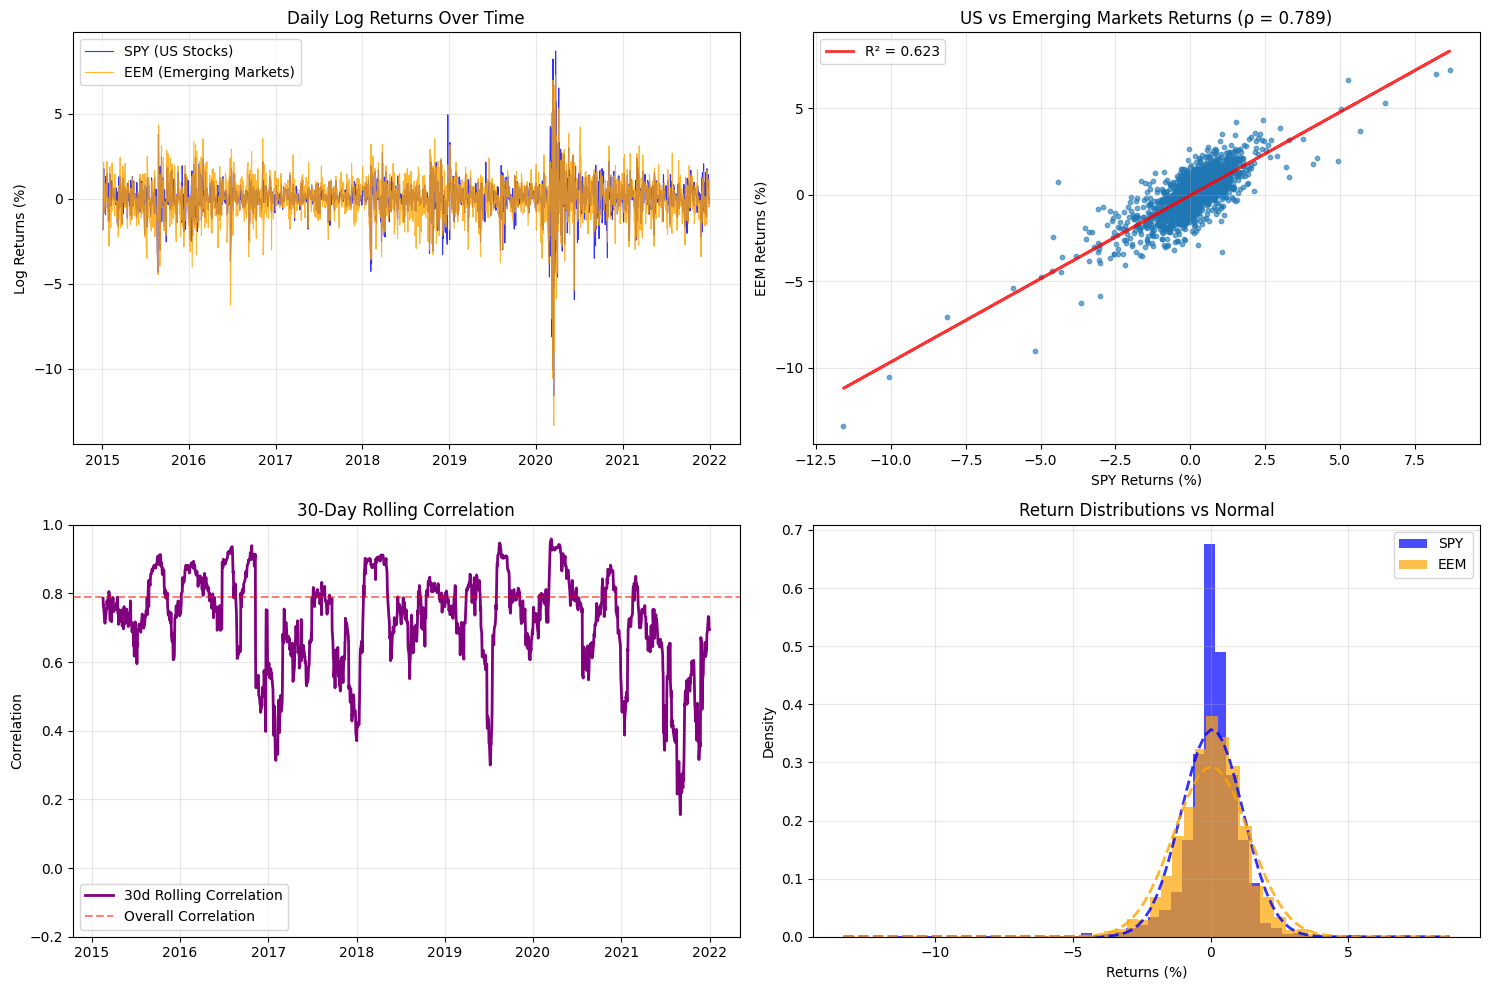

📊 DETAILED DATA SUMMARY
Period: 2015-01-05 to 2021-12-31
Observations: 1762 trading days

DESCRIPTIVE STATISTICS:
  SPY: μ= 0.055%, σ= 1.12%, Skew=-1.037, Kurt=18.489
  EEM: μ= 0.021%, σ= 1.36%, Skew=-1.028, Kurt=10.135

CORRELATION & VOLATILITY:
  Overall Correlation: 0.7893
  Correlation Range: [0.155, 0.959]
  Annualized volatility - SPY: 17.75%, EEM: 21.64%

EXTREME EVENTS (1% tails):
  SPY: worst < -3.25% (18 days), best > 2.55% (18 days)
  EEM: worst < -3.51% (18 days), best > 3.19% (18 days)


In [4]:
def plot_spy_eem_overview(returns_df):
    """Create comprehensive overview plots of SPY and EEM data."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Time series of returns
    ax1 = axes[0, 0]
    ax1.plot(returns_df.index, returns_df['SPY'], label='SPY (US Stocks)', alpha=0.8, linewidth=0.8, color='blue')
    ax1.plot(returns_df.index, returns_df['EEM'], label='EEM (Emerging Markets)', alpha=0.8, linewidth=0.8, color='orange')
    ax1.set_title('Daily Log Returns Over Time')
    ax1.set_ylabel('Log Returns (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot with regression line
    ax2 = axes[0, 1]
    ax2.scatter(returns_df['SPY'], returns_df['EEM'], alpha=0.6, s=10)
    correlation = returns_df["SPY"].corr(returns_df["EEM"])
    
    # Add regression line
    slope, intercept, r_value, _, _ = stats.linregress(returns_df['SPY'], returns_df['EEM'])
    line = slope * returns_df['SPY'] + intercept
    ax2.plot(returns_df['SPY'], line, 'r-', alpha=0.8, linewidth=2, label=f'R² = {r_value**2:.3f}')
    ax2.set_xlabel('SPY Returns (%)')
    ax2.set_ylabel('EEM Returns (%)')
    ax2.set_title(f'US vs Emerging Markets Returns (ρ = {correlation:.3f})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Rolling correlation (30-day window)
    ax3 = axes[1, 0]
    window = 30
    rolling_corr = returns_df['SPY'].rolling(window=window).corr(returns_df['EEM'])
    
    ax3.plot(returns_df.index, rolling_corr, label=f'{window}d Rolling Correlation', linewidth=2, color='purple')
    ax3.axhline(y=correlation, color='red', linestyle='--', alpha=0.5, label='Overall Correlation')
    ax3.set_title(f'{window}-Day Rolling Correlation')
    ax3.set_ylabel('Correlation')
    ax3.set_ylim(-0.2, 1)  # Adjusted for typical range of this pair
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Distribution comparison
    ax4 = axes[1, 1]
    ax4.hist(returns_df['SPY'], bins=50, alpha=0.7, label='SPY', density=True, color='blue')
    ax4.hist(returns_df['EEM'], bins=50, alpha=0.7, label='EEM', density=True, color='orange')
    
    # Normal distribution overlays
    x_range = np.linspace(min(returns_df['SPY'].min(), returns_df['EEM'].min()),
                         max(returns_df['SPY'].max(), returns_df['EEM'].max()), 100)
    
    for col, color, style in [('SPY', 'blue', '--'), ('EEM', 'orange', '--')]:
        normal_dist = stats.norm.pdf(x_range, returns_df[col].mean(), returns_df[col].std())
        ax4.plot(x_range, normal_dist, color=color, linestyle=style, alpha=0.8, linewidth=2)
    
    ax4.set_xlabel('Returns (%)')
    ax4.set_ylabel('Density')
    ax4.set_title('Return Distributions vs Normal')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("📊 DETAILED DATA SUMMARY")
    print("=" * 50)
    print(f"Period: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")
    print(f"Observations: {len(returns_df)} trading days")
    
    print("\nDESCRIPTIVE STATISTICS:")
    for col in ['SPY', 'EEM']:
        data = returns_df[col]
        print(f"  {col:>3}: μ={data.mean():6.3f}%, σ={data.std():5.2f}%, "
              f"Skew={data.skew():6.3f}, Kurt={data.kurtosis():6.3f}")
    
    print(f"\nCORRELATION & VOLATILITY:")
    print(f"  Overall Correlation: {correlation:.4f}")
    print(f"  Correlation Range: [{rolling_corr.min():.3f}, {rolling_corr.max():.3f}]")
    spy_ann = returns_df['SPY'].std() * np.sqrt(252)
    eem_ann = returns_df['EEM'].std() * np.sqrt(252)
    print(f"  Annualized volatility - SPY: {spy_ann:.2f}%, EEM: {eem_ann:.2f}%")
    
    print(f"\nEXTREME EVENTS (1% tails):")
    for col in ['SPY', 'EEM']:
        data = returns_df[col]
        q01, q99 = data.quantile([0.01, 0.99])
        extreme_down = (data <= q01).sum()
        extreme_up = (data >= q99).sum()
        print(f"  {col:>3}: worst < {q01:.2f}% ({extreme_down} days), "
              f"best > {q99:.2f}% ({extreme_up} days)")

# Create the visualization
plot_spy_eem_overview(returns_df)

### Train/Test Split

Split the data into training and testing sets for out-of-sample model evaluation.

In [5]:
def split_data_2d(returns_df, returns_array, train_ratio=0.7):
    """Split 2D data into training and testing sets."""
    n_total = len(returns_df)
    n_train = int(n_total * train_ratio)
    
    # Split data
    train_df = returns_df.iloc[:n_train].copy()
    test_df = returns_df.iloc[n_train:].copy()
    train_array = returns_array[:n_train]
    test_array = returns_array[n_train:]
    
    print(f"📊 Data Split Summary:")
    print(f"   Training: {len(train_df)} days ({train_df.index[0].date()} to {train_df.index[-1].date()})")
    print(f"   Testing:  {len(test_df)} days ({test_df.index[0].date()} to {test_df.index[-1].date()})")
    print(f"   Training correlation: {train_df['SPY'].corr(train_df['EEM']):.3f}")
    print(f"   Testing correlation:  {test_df['SPY'].corr(test_df['EEM']):.3f}")
    print(f"   Array shapes: Train{train_array.shape}, Test{test_array.shape}")
    
    return train_df, test_df, train_array, test_array

# Split the data
train_df, test_df, train_array, test_array = split_data_2d(returns_df, returns_array, train_ratio=0.7)

# Store individual series for convenience
spy_train, eem_train = train_df['SPY'].values, train_df['EEM'].values
spy_test, eem_test = test_df['SPY'].values, test_df['EEM'].values

print("✅ Data split completed successfully")

📊 Data Split Summary:
   Training: 1233 days (2015-01-05 to 2019-11-25)
   Testing:  529 days (2019-11-26 to 2021-12-31)
   Training correlation: 0.764
   Testing correlation:  0.824
   Array shapes: Train(1233, 2), Test(529, 2)
✅ Data split completed successfully


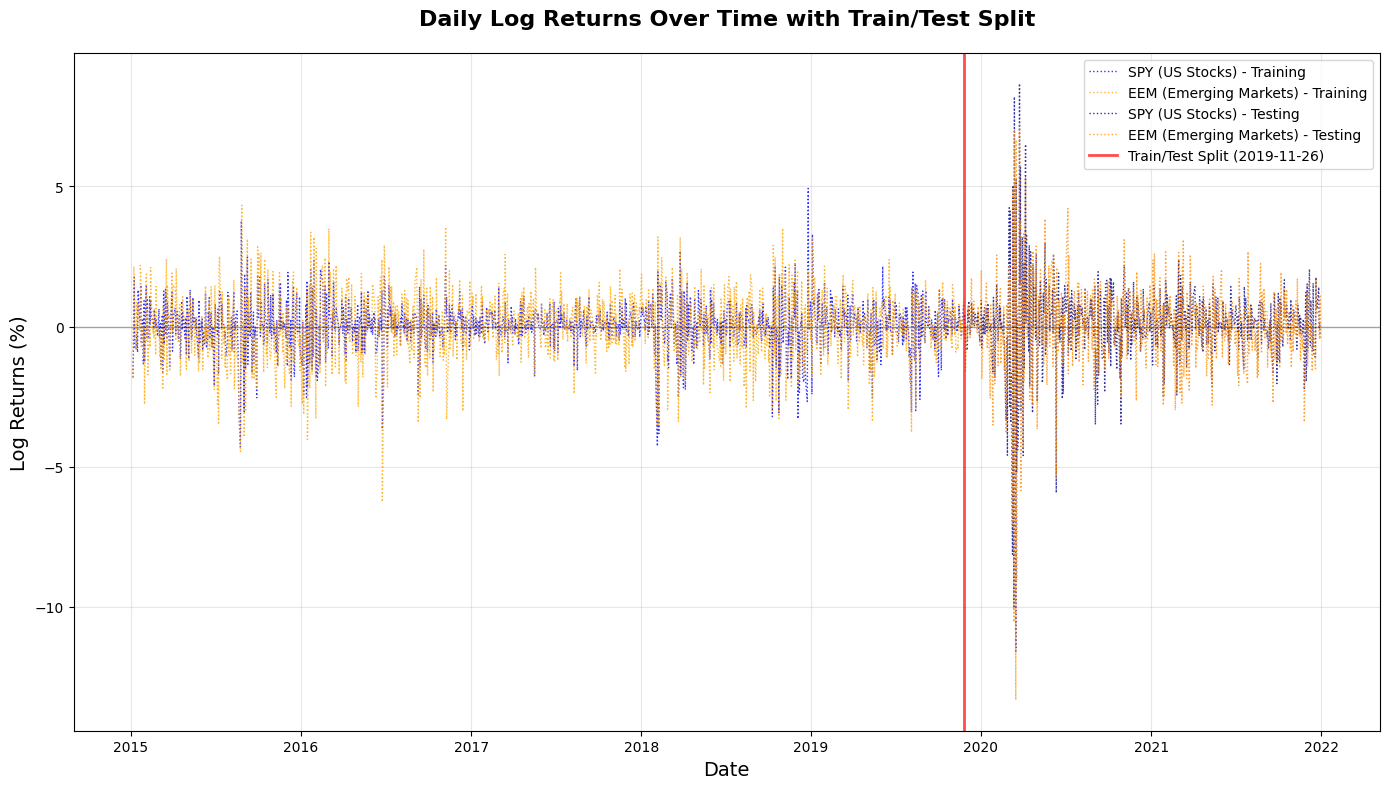


📊 TIME SERIES WITH TRAIN/TEST SPLIT
Total Period: 2015-01-05 to 2021-12-31
Total Trading Days: 1762
Training Split: 1233 days (70.0%)
Testing Split: 529 days (30.0%)
Split Date: 2019-11-26

Correlation Analysis:
Overall Correlation: 0.789
Training Correlation: 0.764
Testing Correlation: 0.824

Volatility Comparison:
SPY Training Vol: 0.853%  |  Testing Vol: 1.572%
EEM Training Vol: 1.193%  |  Testing Vol: 1.696%


In [7]:
def plot_returns_with_split(returns_df, train_df, test_df):
    """
    Create time series plot of SPY and EEM returns with train/test split visualization
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculate split date
    split_date = test_df.index[0]
    
    # Plot training data (dotted lines)
    ax.plot(train_df.index, train_df['SPY'], 
            label='SPY (US Stocks) - Training', alpha=0.8, linewidth=1, color='blue', linestyle=':')
    ax.plot(train_df.index, train_df['EEM'], 
            label='EEM (Emerging Markets) - Training', alpha=0.8, linewidth=1, color='orange', linestyle=':')
    
    # Plot testing data (dotted lines, different colors)
    ax.plot(test_df.index, test_df['SPY'], 
            label='SPY (US Stocks) - Testing', alpha=0.8, linewidth=1, color='darkblue', linestyle=':')
    ax.plot(test_df.index, test_df['EEM'], 
            label='EEM (Emerging Markets) - Testing', alpha=0.8, linewidth=1, color='darkorange', linestyle=':')
    
    # Add vertical line for split
    ax.axvline(x=split_date, color='red', linestyle='-', linewidth=2, alpha=0.7, 
               label=f'Train/Test Split ({split_date.date()})')
    
    # Add zero line
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    # Formatting
    ax.set_title('Daily Log Returns Over Time with Train/Test Split', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('Log Returns (%)', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.tick_params(axis='x', rotation=0, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print split summary
    print("\n" + "="*60)
    print("📊 TIME SERIES WITH TRAIN/TEST SPLIT")
    print("="*60)
    print(f"Total Period: {returns_df.index[0].strftime('%Y-%m-%d')} to {returns_df.index[-1].strftime('%Y-%m-%d')}")
    print(f"Total Trading Days: {len(returns_df)}")
    print(f"Training Split: {len(train_df)} days ({len(train_df)/len(returns_df):.1%})")
    print(f"Testing Split: {len(test_df)} days ({len(test_df)/len(returns_df):.1%})")
    print(f"Split Date: {split_date.strftime('%Y-%m-%d')}")
    
    print("\nCorrelation Analysis:")
    overall_corr = returns_df['SPY'].corr(returns_df['EEM'])
    train_corr = train_df['SPY'].corr(train_df['EEM'])
    test_corr = test_df['SPY'].corr(test_df['EEM'])
    print(f"Overall Correlation: {overall_corr:.3f}")
    print(f"Training Correlation: {train_corr:.3f}")
    print(f"Testing Correlation: {test_corr:.3f}")
    
    print("\nVolatility Comparison:")
    print(f"SPY Training Vol: {train_df['SPY'].std():.3f}%  |  Testing Vol: {test_df['SPY'].std():.3f}%")
    print(f"EEM Training Vol: {train_df['EEM'].std():.3f}%  |  Testing Vol: {test_df['EEM'].std():.3f}%")

# Create the plot
plot_returns_with_split(returns_df, train_df, test_df)

In [7]:
class DC_MSV(ssm.StateSpaceModel):
    """
    Dynamic Conditional Multivariate Stochastic Volatility Model
    
    State: [h1_t, h2_t, q_t] where h1,h2 are log-volatilities, q is transformed correlation
    """
    def __init__(self, mu1, mu2, phi11, phi22, sigma_eta1, sigma_eta2, psi0, psi, sigma_rho):
        # Store parameters
        self.mu1, self.mu2 = mu1, mu2
        self.phi11, self.phi22 = phi11, phi22
        self.sigma_eta1, self.sigma_eta2 = sigma_eta1, sigma_eta2
        self.psi0, self.psi = psi0, psi
        self.sigma_rho = sigma_rho
        
        # State transition matrices
        self.a = np.array([mu1 * (1 - phi11), mu2 * (1 - phi22), psi0 * (1 - psi)])
        self.B = np.diag([phi11, phi22, psi])
        self.Sigma = np.diag([sigma_eta1**2, sigma_eta2**2, sigma_rho**2])

    def PX0(self):
        """Initial state distribution"""
        return distributions.MvNormal(loc=np.array([self.mu1, self.mu2, self.psi0]), cov=np.eye(3))

    def PX(self, t, xp):
        """State transition: X_t | X_{t-1}"""
        mean = self.a + np.dot(self.B, xp.T).T
        return distributions.MvNormal(loc=mean, cov=self.Sigma)

    def PY(self, t, xp, x):
        """Observation distribution: Y_t | X_t"""
        h1, h2, q = x[:, 0], x[:, 1], x[:, 2]
        
        # Transform to correlation and volatilities
        rho = np.clip((np.exp(q) - 1) / (np.exp(q) + 1), -0.999, 0.999)
        vol1, vol2 = np.exp(h1 / 2), np.exp(h2 / 2)
        
        class VectorizedBivariateNormal:
            """Custom vectorized bivariate normal for particle filtering"""
            def __init__(self, vol1, vol2, rho):
                self.vol1, self.vol2, self.rho = vol1, vol2, rho
                self.N = len(vol1)
            
            def logpdf(self, y):
                if len(y.shape) == 1:
                    y = y.reshape(1, -1)
                
                logpdfs = np.zeros(self.N)
                for i in range(self.N):
                    # Covariance matrix for particle i
                    var1, var2 = self.vol1[i]**2 + 1e-6, self.vol2[i]**2 + 1e-6
                    cov12 = self.rho[i] * self.vol1[i] * self.vol2[i]
                    cov_i = np.array([[var1, cov12], [cov12, var2]])
                    
                    # Log-likelihood calculation
                    det_cov = np.linalg.det(cov_i)
                    if det_cov <= 0:
                        logpdfs[i] = -np.inf
                    else:
                        diff = y[0]  # y is (1, 2)
                        inv_cov = np.linalg.inv(cov_i)
                        exponent = -0.5 * diff @ inv_cov @ diff.T
                        normalization = -0.5 * (2 * np.log(2 * np.pi) + np.log(det_cov))
                        logpdfs[i] = exponent + normalization
                
                return logpdfs
            
            def rvs(self, size=None):
                if size is None:
                    size = self.N
                samples = np.zeros((size, 2))
                for i in range(size):
                    particle_idx = i % self.N
                    var1 = self.vol1[particle_idx]**2 + 1e-6
                    var2 = self.vol2[particle_idx]**2 + 1e-6
                    cov12 = self.rho[particle_idx] * self.vol1[particle_idx] * self.vol2[particle_idx]
                    cov_i = np.array([[var1, cov12], [cov12, var2]])
                    samples[i] = np.random.multivariate_normal(np.zeros(2), cov_i)
                return samples
        
        return VectorizedBivariateNormal(vol1, vol2, rho)

### Baseline Model: Bivariate Normal

Simple constant covariance model for comparison (equivalent to 2D Black-Scholes assumption).

In [8]:
class BivariateNormal(ssm.StateSpaceModel):
    """Simple constant bivariate normal model (2D Black-Scholes equivalent)"""
    
    def __init__(self, data):
        self.data = np.array(data)
        self.mean = np.mean(self.data, axis=0)  # Should be close to [0, 0]
        self.cov = np.cov(self.data.T) + 1e-6 * np.eye(2)  # Add regularization
    
    def PX0(self):
        """Dummy initial state"""
        return distributions.MvNormal(loc=np.zeros(2), cov=0.001 * np.eye(2))
    
    def PX(self, t, xp):
        """Dummy state transition"""
        return distributions.MvNormal(loc=xp, cov=0.0001 * np.eye(2))
    
    def PY(self, t, xp, x):
        """Observation model: Y_t ~ N(μ, Σ) with constant parameters"""
        N = len(x)
        
        class ConstantBivariateNormal:
            def __init__(self, mean, cov, N):
                self.mean, self.cov, self.N = mean, cov, N
            
            def logpdf(self, y):
                if len(y.shape) == 1:
                    y = y.reshape(1, -1)
                
                diff = y[0] - self.mean
                det_cov = np.linalg.det(self.cov)
                
                if det_cov <= 0:
                    return np.full(self.N, -np.inf)
                
                inv_cov = np.linalg.inv(self.cov)
                exponent = -0.5 * diff @ inv_cov @ diff.T
                normalization = -0.5 * (2 * np.log(2 * np.pi) + np.log(det_cov))
                return np.full(self.N, exponent + normalization)
            
            def rvs(self, size=None):
                if size is None:
                    size = self.N
                return np.random.multivariate_normal(self.mean, self.cov, size)
        
        return ConstantBivariateNormal(self.mean, self.cov, N)

## 3. Bayesian Parameter Estimation

### HMC/NUTS Estimation with NumPyro

Efficient Bayesian estimation using Hamiltonian Monte Carlo with non-centered parameterization for improved sampling efficiency.

In [10]:
def numpyro_estimation_dc_msv(returns_array, n_iter=10000, n_warmup=2000, n_chains=2):
    """
    Optimized HMC estimation for DC-MSV model using non-centered parameterization.
    
    Args:
        returns_array: (T, 2) array of returns
        n_iter: Total iterations per chain
        n_warmup: Warmup iterations
        n_chains: Number of parallel chains
    
    Returns:
        dict: MCMC results and parameter estimates
    """
    jax.config.update("jax_platform_name", "cpu")
    T, _ = returns_array.shape
    y_data = jnp.array(returns_array)
    
    def dc_msv_model(y=None):
        # Prior distributions
        # Use data-informed priors
        y_mean = jnp.mean(jnp.log(jnp.var(y_data, axis=0) + 1e-6))  # Empirical log-variance
        mu1 = numpyro.sample('mu1', dist.Normal(y_mean, 1.0))  # Tighter, data-informed
        mu2 = numpyro.sample('mu2', dist.Normal(y_mean, 1.0))
        phi11 = numpyro.sample('phi11', dist.Beta(20., 1.5))
        phi22 = numpyro.sample('phi22', dist.Beta(20., 1.5))
        sigma1 = numpyro.sample('sigma1', dist.InverseGamma(2.5, 0.025))
        sigma2 = numpyro.sample('sigma2', dist.InverseGamma(2.5, 0.025))
        mu0 = numpyro.sample('mu0', dist.Normal(0.7, 3.))
        phi = numpyro.sample('phi', dist.Beta(20., 1.5))
        sigma_rho = numpyro.sample('sigma_rho', dist.InverseGamma(2.5, 0.025))

        # Stationary variances for initial states
        var_h1 = sigma1**2 / (1 - phi11**2 + 1e-6)
        var_h2 = sigma2**2 / (1 - phi22**2 + 1e-6)
        var_q = sigma_rho**2 / (1 - phi**2 + 1e-6)

        # Non-centered initial states
        h1_0_tilde = numpyro.sample('h1_0_tilde', dist.Normal(0., 1.))
        h2_0_tilde = numpyro.sample('h2_0_tilde', dist.Normal(0., 1.))
        q_0_tilde = numpyro.sample('q_0_tilde', dist.Normal(0., 1.))

        h1_init = mu1 + jnp.sqrt(var_h1) * h1_0_tilde
        h2_init = mu2 + jnp.sqrt(var_h2) * h2_0_tilde
        q_init = mu0 + jnp.sqrt(var_q) * q_0_tilde
        init_state = jnp.array([h1_init, h2_init, q_init])

        # Non-centered innovations for state transitions
        with numpyro.plate('time', T-1):
            h1_tilde = numpyro.sample('h1_tilde', dist.Normal(0., 1.))
            h2_tilde = numpyro.sample('h2_tilde', dist.Normal(0., 1.))
            q_tilde = numpyro.sample('q_tilde', dist.Normal(0., 1.))

        tildes = jnp.stack([h1_tilde, h2_tilde, q_tilde], axis=1)

        # State evolution using scan
        def state_step(state_prev, tilde):
            h1_prev, h2_prev, q_prev = state_prev
            h1 = mu1 + phi11 * (h1_prev - mu1) + sigma1 * tilde[0]
            h2 = mu2 + phi22 * (h2_prev - mu2) + sigma2 * tilde[1]
            q = mu0 + phi * (q_prev - mu0) + sigma_rho * tilde[2]
            new_state = jnp.array([h1, h2, q])
            return new_state, new_state

        _, states_rest = lax.scan(state_step, init_state, tildes)
        states = jnp.concatenate([init_state[None, :], states_rest], axis=0)
        numpyro.deterministic('states', states)

        # Observation model
        with numpyro.plate('obs', T):
            h1, h2, q = states[:, 0], states[:, 1], states[:, 2]
            rho_t = (jnp.exp(q) - 1) / (jnp.exp(q) + 1)
            Omega_t = jnp.stack([jnp.exp(h1 / 2), jnp.exp(h2 / 2)], axis=1)
            
            # Time-varying covariance matrices
            covs = jnp.zeros((T, 2, 2))
            covs = covs.at[:, 0, 0].set(Omega_t[:, 0]**2)
            covs = covs.at[:, 1, 1].set(Omega_t[:, 1]**2)
            covs = covs.at[:, 0, 1].set(rho_t * Omega_t[:, 0] * Omega_t[:, 1])
            covs = covs.at[:, 1, 0].set(rho_t * Omega_t[:, 0] * Omega_t[:, 1])
            covs = covs + 1e-5 * jnp.eye(2)  # Regularization
            
            numpyro.sample('y', dist.MultivariateNormal(loc=jnp.zeros(2), covariance_matrix=covs), obs=y)

    print(f"Running DC-MSV estimation ({n_chains} chains, {n_iter} iterations each)...")
    
    # Run NUTS sampler
    nuts_kernel = NUTS(dc_msv_model)
    mcmc = MCMC(nuts_kernel, num_warmup=n_warmup, num_samples=n_iter - n_warmup, 
                num_chains=n_chains, progress_bar=True)
    mcmc.run(jax.random.PRNGKey(0), y=y_data)
    
    # Extract and summarize results
    samples = mcmc.get_samples()
    params = ['mu1', 'mu2', 'phi11', 'phi22', 'sigma1', 'sigma2', 'mu0', 'phi', 'sigma_rho']
    param_estimates = {}
    
    for param in params:
        param_samples = samples[param]
        param_estimates[param] = {
            'mean': float(jnp.mean(param_samples)),
            'std': float(jnp.std(param_samples)),
            'quantiles': [float(q) for q in jnp.quantile(param_samples, jnp.array([0.025, 0.5, 0.975]))]
        }
    
    print("NumPyro estimation completed")
    print("\nParameter Estimates (Posterior Means):")
    print("-" * 50)
    for param, est in param_estimates.items():
        print(f"  {param:>10}: {est['mean']:7.4f} ± {est['std']:6.4f}")
    
    return {
        'mcmc': mcmc,
        'samples': samples,
        'estimates': param_estimates,
        'param_names': params
    }

In [11]:
# === MODEL FITTING PIPELINE ===

print("Starting model fitting pipeline...")

# 1. Convert returns to decimal scale (from percentage)
train_array_decimal = train_array / 100
test_array_decimal = test_array / 100

# 2. Create baseline model
baseline_model = BivariateNormal(train_array_decimal)
print("Baseline bivariate normal model created")

# 3. Run Bayesian parameter estimation
print("\nRunning HMC estimation for DC-MSV parameters...")
results = numpyro_estimation_dc_msv(train_array_decimal, n_iter=20000, n_warmup=5000)

Starting model fitting pipeline...
Baseline bivariate normal model created

Running HMC estimation for DC-MSV parameters...
Running DC-MSV estimation (2 chains, 20000 iterations each)...


sample: 100%|██████████| 20000/20000 [08:22<00:00, 39.80it/s, 63 steps of size 6.55e-02. acc. prob=0.89]


NumPyro estimation completed

Parameter Estimates (Posterior Means):
--------------------------------------------------
         mu1: -10.2516 ± 0.3020
         mu2: -9.1631 ± 0.2011
       phi11:  0.9711 ± 0.0102
       phi22:  0.9768 ± 0.0106
      sigma1:  0.2774 ± 0.0392
      sigma2:  0.1348 ± 0.0290
         mu0:  2.9690 ± 0.1710
         phi:  0.9306 ± 0.0533
   sigma_rho:  0.0517 ± 0.1038



Running MCMC diagnostics...

MCMC CONVERGENCE DIAGNOSTICS
Total iterations: 30000
Post-burnin samples: 30000

Effective Sample Sizes:
  Volatility parameters:
    mu1: 8136 (27.1%)
    mu2: 9070 (30.2%)
    phi11: 5403 (18.0%)
    phi22: 5009 (16.7%)
    sigma1: 4313 (14.4%)
    sigma2: 4058 (13.5%)
  Correlation parameters:
    mu0: 1967 (6.6%)
    phi: 20500 (68.3%)
    sigma_rho: 624 (2.1%)


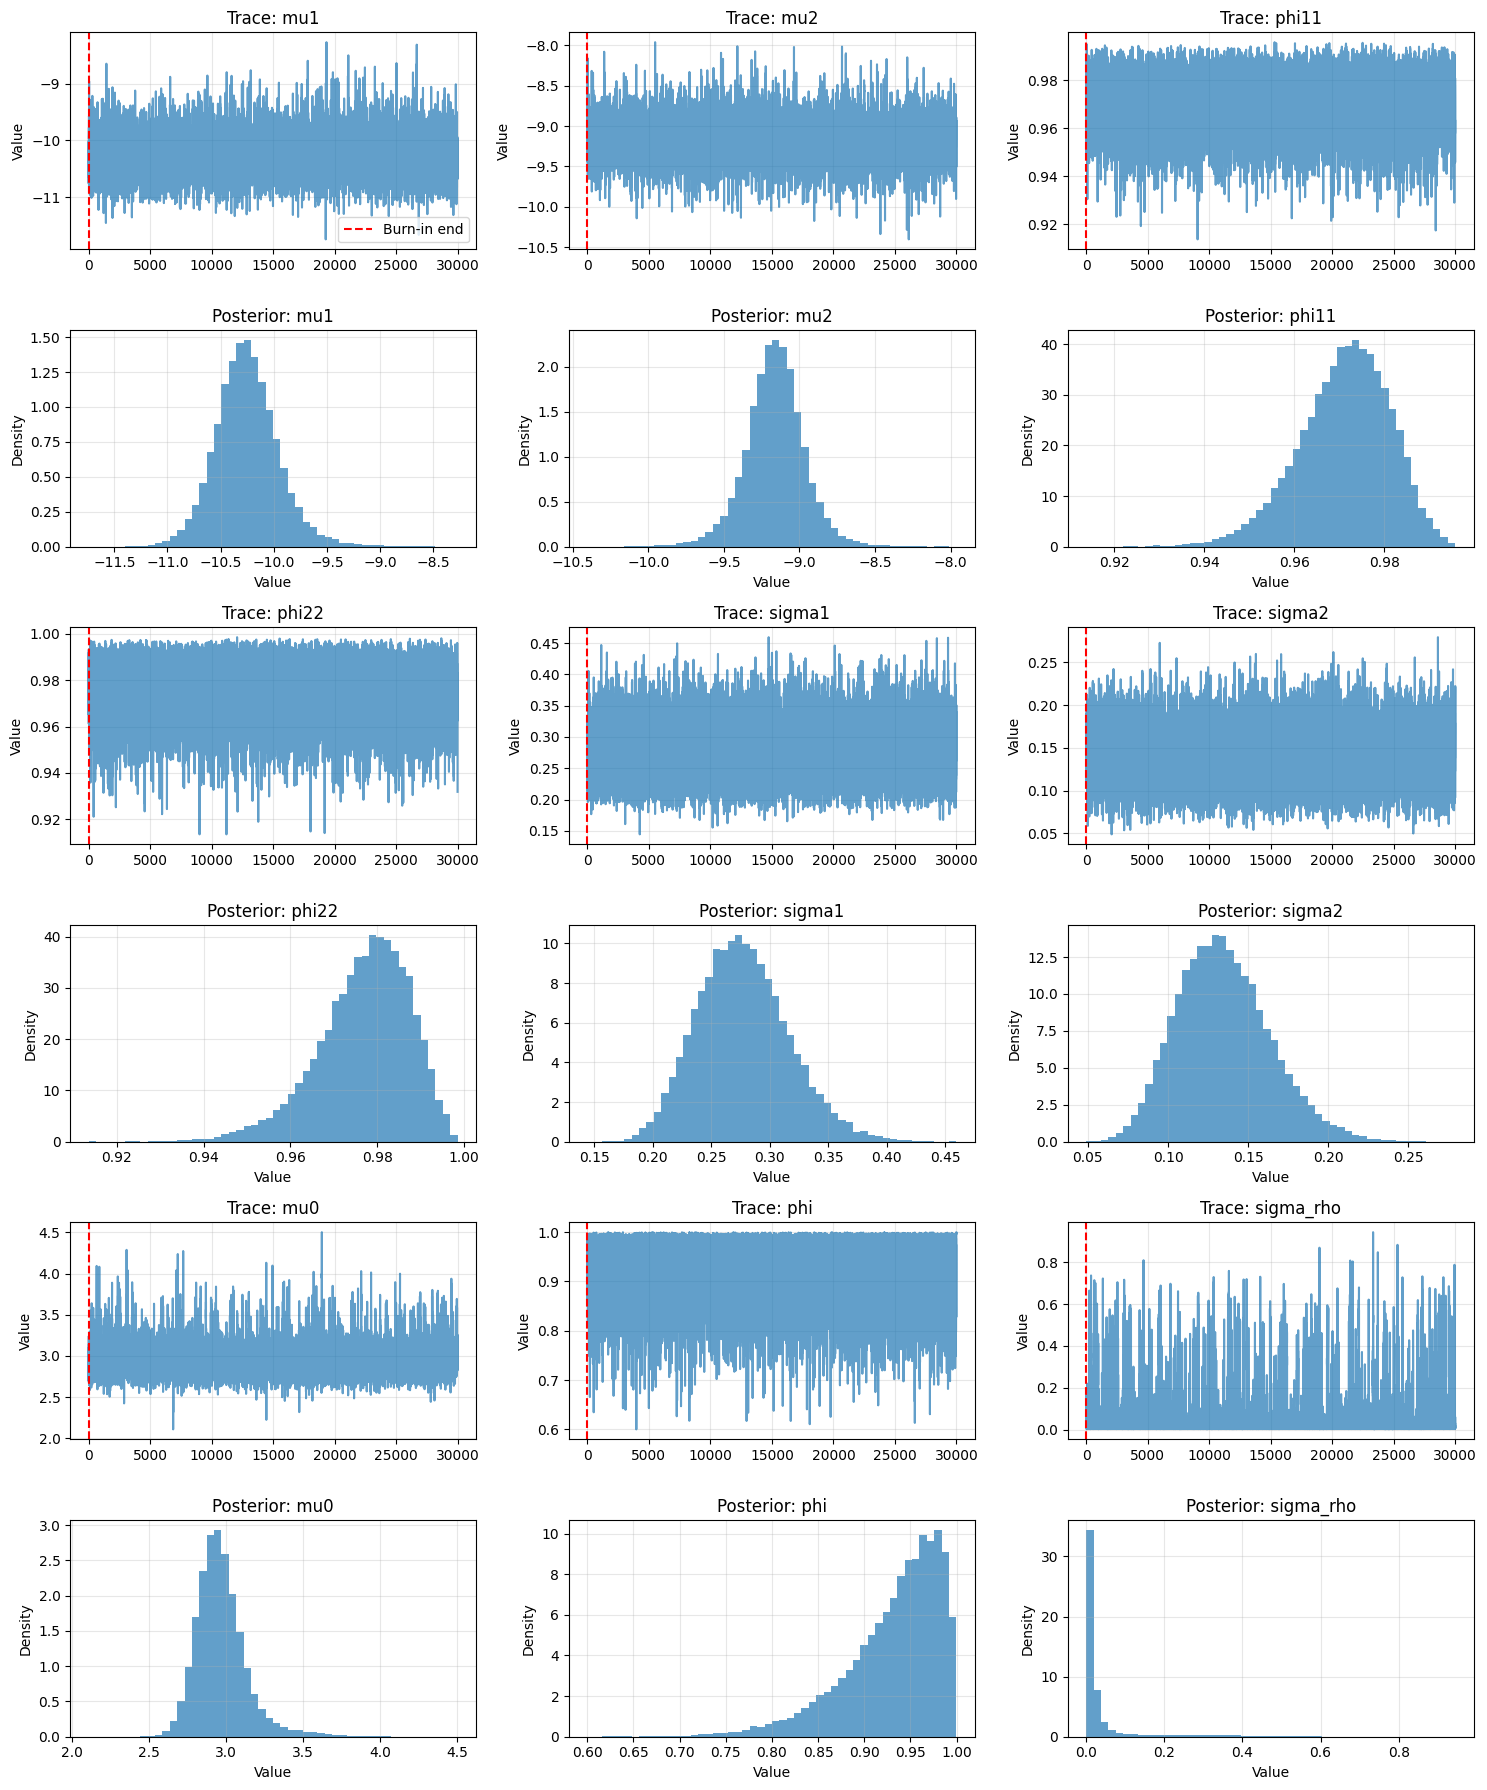

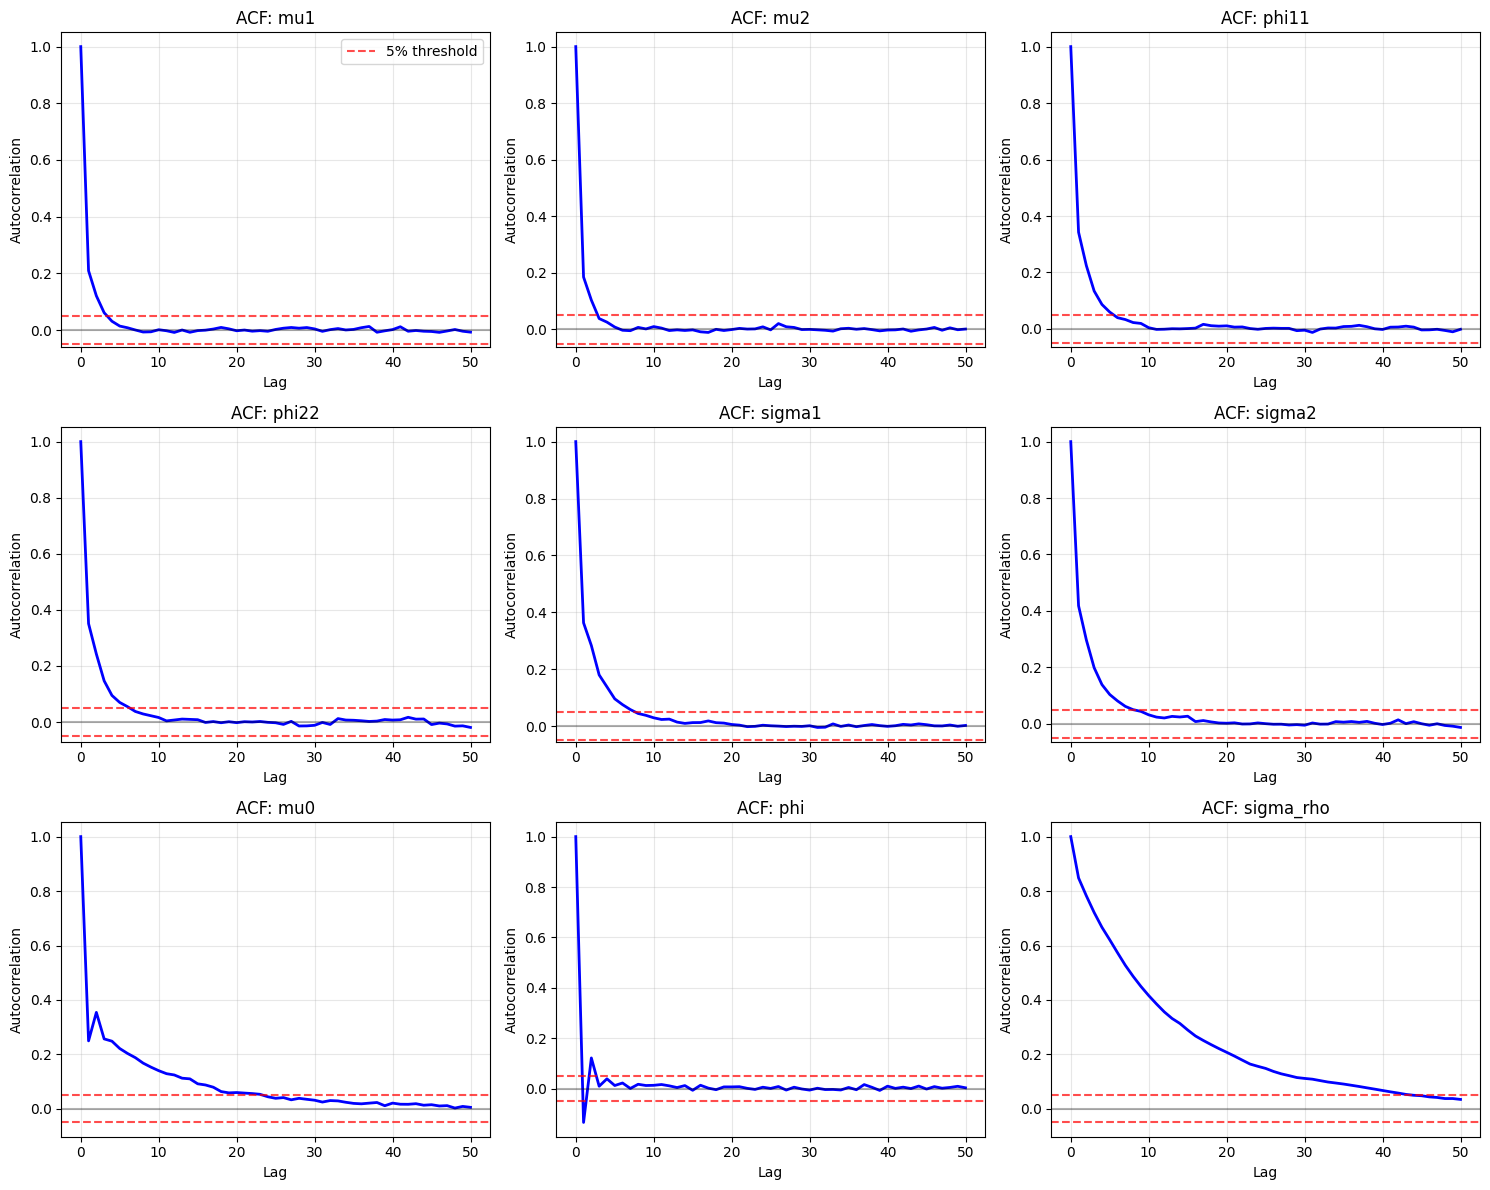


PARAMETER SUMMARY STATISTICS
------------------------------------------------------------
Parameter    Mean       Std        95% CI              
------------------------------------------------------------
mu1          -10.2516   0.3020     [-10.8147, -9.6116]
mu2          -9.1631    0.2011     [-9.5744, -8.7717]
phi11        0.9711     0.0102     [0.9490, 0.9884]
phi22        0.9768     0.0106     [0.9518, 0.9934]
sigma1       0.2774     0.0392     [0.2079, 0.3612]
sigma2       0.1348     0.0290     [0.0840, 0.1972]
mu0          2.9690     0.1710     [2.7042, 3.3920]
phi          0.9306     0.0533     [0.7965, 0.9946]
sigma_rho    0.0517     0.1038     [0.0041, 0.4074]

ADDITIONAL DIAGNOSTICS
R-hat values not available

Diagnostics completed. Average ESS: 6565


In [12]:
def plot_acf(chain, param_names, max_lags=50):
    """Plot autocorrelation function for MCMC chains"""
    n_params = len(param_names)
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_params > 1 else [axes]
    
    for i, param in enumerate(param_names):
        autocorr = acf(chain[:, i], nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))
        
        axes[i].plot(lags, autocorr, 'b-', linewidth=2)
        axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% threshold')
        axes[i].axhline(y=-0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Autocorrelation')
        axes[i].set_title(f'ACF: {param}')
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend()
    
    # Hide empty subplots
    for i in range(n_params, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def effective_sample_size(chain):
    """Calculate effective sample size for MCMC chains"""
    n_samples, n_params = chain.shape
    ess_values = []
    
    for i in range(n_params):
        max_lags = min(n_samples // 4, 200)
        try:
            autocorrs = acf(chain[:, i], nlags=max_lags, fft=True)
            
            # Find cutoff where autocorrelation drops below threshold
            cutoff = 1
            for lag in range(1, len(autocorrs)):
                if autocorrs[lag] <= 0.05:
                    cutoff = lag
                    break
            
            # Integrated autocorrelation time and ESS
            tau_int = 1 + 2 * np.sum(autocorrs[1:cutoff+1])
            ess = n_samples / (2 * tau_int)
            ess_values.append(max(ess, 1))
        except:
            ess_values.append(n_samples / 10)  # Conservative fallback
    
    return np.array(ess_values)

def mcmc_diagnostics_2d(chain, param_names, burned_chain):
    """Comprehensive MCMC diagnostics for DC_MSV model"""
    print("\nMCMC CONVERGENCE DIAGNOSTICS")
    print("=" * 50)
    
    n_total, n_params = chain.shape
    n_burned = len(burned_chain)
    
    print(f"Total iterations: {n_total}")
    print(f"Post-burnin samples: {n_burned}")
    
    # Effective sample size
    ess = effective_sample_size(burned_chain)
    print(f"\nEffective Sample Sizes:")
    
    # Group parameters by type
    vol_params = ['mu1', 'mu2', 'phi11', 'phi22', 'sigma1', 'sigma2']
    corr_params = ['mu0', 'phi', 'sigma_rho']
    
    print("  Volatility parameters:")
    for param in vol_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"    {param}: {ess[i]:.0f} ({ess[i]/n_burned:.1%})")
    
    print("  Correlation parameters:")
    for param in corr_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"    {param}: {ess[i]:.0f} ({ess[i]/n_burned:.1%})")
    
    # Create trace and density plots
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(15, n_rows * 6))
    
    for i, param in enumerate(param_names):
        row_trace = 2 * (i // n_cols)
        row_dens = row_trace + 1
        col = i % n_cols
        
        # Trace plot
        axes[row_trace, col].plot(chain[:, i], alpha=0.7)
        axes[row_trace, col].axvline(x=n_total-n_burned, color='r', linestyle='--', 
                                     label='Burn-in end' if i == 0 else "")
        axes[row_trace, col].set_title(f'Trace: {param}')
        axes[row_trace, col].set_ylabel('Value')
        axes[row_trace, col].grid(True, alpha=0.3)
        if i == 0:
            axes[row_trace, col].legend()
        
        # Density plot
        axes[row_dens, col].hist(burned_chain[:, i], bins=50, density=True, alpha=0.7)
        axes[row_dens, col].set_title(f'Posterior: {param}')
        axes[row_dens, col].set_xlabel('Value')
        axes[row_dens, col].set_ylabel('Density')
        axes[row_dens, col].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_params, n_rows * n_cols):
        for j in [0, 1]:  # Both trace and density rows
            row = 2 * (i // n_cols) + j
            col = i % n_cols
            if row < len(axes):
                axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Plot ACF
    plot_acf(burned_chain, param_names)
    
    # Summary statistics table
    print("\nPARAMETER SUMMARY STATISTICS")
    print("-" * 60)
    print(f"{'Parameter':<12} {'Mean':<10} {'Std':<10} {'95% CI':<20}")
    print("-" * 60)
    
    for i, param in enumerate(param_names):
        mean = np.mean(burned_chain[:, i])
        std = np.std(burned_chain[:, i])
        ci_low, ci_high = np.percentile(burned_chain[:, i], [2.5, 97.5])
        print(f"{param:<12} {mean:<10.4f} {std:<10.4f} [{ci_low:.4f}, {ci_high:.4f}]")
    
    return ess

def convert_numpyro_to_chain(numpyro_results):
    """Convert NumPyro results to chain format for diagnostics"""
    samples = numpyro_results['samples']
    param_names = numpyro_results['param_names']
    
    n_samples = len(samples[param_names[0]])
    n_params = len(param_names)
    
    chain = np.zeros((n_samples, n_params))
    for i, param in enumerate(param_names):
        chain[:, i] = np.array(samples[param])
    
    # NumPyro already excludes warmup
    burned_chain = chain
    return chain, burned_chain

# === RUN DIAGNOSTICS ===
print("\nRunning MCMC diagnostics...")

# Convert NumPyro results to chain format
chain, burned_chain = convert_numpyro_to_chain(results)

# Run comprehensive diagnostics
ess = mcmc_diagnostics_2d(chain, results['param_names'], burned_chain)

# NumPyro-specific diagnostics
print("\nADDITIONAL DIAGNOSTICS")
print("=" * 50)

# Try to get R-hat values
try:
    if hasattr(results['mcmc'], 'get_extra_fields'):
        r_hat = results['mcmc'].get_extra_fields().get('r_hat', {})
        if r_hat:
            print("Gelman-Rubin R-hat values:")
            for param in results['param_names']:
                if param in r_hat:
                    print(f"  {param}: {r_hat[param]:.3f}")
        else:
            print("R-hat values not available")
    else:
        print("R-hat values not available (single chain)")
except Exception as e:
    print(f"R-hat calculation error: {e}")

print(f"\nDiagnostics completed. Average ESS: {np.mean(ess):.0f}")

## 4. Model Evaluation: Out-of-Sample Performance

### Negative Log Predictive Density (NLPD) Comparison

Evaluate model performance using particle filtering on the test set to compute predictive likelihoods.

### Online Filtering and Robust Model Comparison

In [13]:
from particles_cdssm.collectors import NLPD
from scipy.stats import gaussian_kde
import numpy as np

class NLPD_Diagnostic(NLPD):
    """
    Standard NLPD with diagnostic tracking for spike analysis.
    No capping, no cooking - just honest evaluation with logging.
    """
    def __init__(self, spike_threshold=10.0, **kwargs):
        super().__init__(**kwargs)
        self.spike_threshold = spike_threshold
        self.time_step = -1  # Will be incremented to 0 on first call
        self.spike_info = []  # Store info about spikes
        
    def out_func_Y(self, wgts, Y):
        """Returns honest NLPD with diagnostic tracking."""
        if not self.has_y_true:
            return None
        
        self.time_step += 1
        
        # Standard NLPD calculation
        W = wgts.W if not self.rs_flag else None
        kde = gaussian_kde(Y.T, weights=W)
        log_p = kde.logpdf(self.y_true)
        
        if isinstance(log_p, np.ndarray):
            log_p = float(log_p.item())
            
        nlpd = -1. * log_p
        
        # Track spikes for later analysis (but don't modify the value!)
        if nlpd > self.spike_threshold:
            spike_data = {
                'time_step': self.time_step,
                'nlpd': float(nlpd),
                'observation': self.y_true.copy() if hasattr(self.y_true, 'copy') else self.y_true,
                'particle_mean': np.mean(Y, axis=0),
                'particle_std': np.std(Y, axis=0),
                'particle_min': np.min(Y, axis=0),
                'particle_max': np.max(Y, axis=0),
                'num_particles': len(Y)
            }
            self.spike_info.append(spike_data)
            
        return nlpd  # Return honest value

🔄 NLPD COMPARISON USING PARTICLE PREDICTIONS

1. Running particle filters with 1000 particles...
   ✅ DC-MSV particle filter completed
   ✅ Bivariate particle filter completed

2. Extracting NLPD values from collectors...
   📊 DC-MSV raw NLPD length: 530
   📊 Bivariate raw NLPD length: 530
   ✅ Successfully extracted NLPD values
   📊 DC-MSV NLPD shape: (528,)
   📊 Bivariate NLPD shape: (528,)

🔍 SPIKE ANALYSIS FOR DC-MSV MODEL

🔍 SPIKE ANALYSIS FOR DC-MSV MODEL
No spikes found above threshold

📊 DETAILED SPIKE ANALYSIS
--------------------------------------------------------------------------------

3. Computing NLPD statistics...

DC-MSV Model:
  Mean NLPD:    -6.1769
  Median NLPD:  -6.6820
  Std NLPD:     2.0397
  Min/Max:      -8.76 / 9.68
  Observations: 528

Bivariate Model:
  Mean NLPD:    -1.4971
  Median NLPD:  -6.9342
  Std NLPD:     36.2256
  Min/Max:      -7.78 / 530.46
  Observations: 528

📊 MODEL COMPARISON SUMMARY:
--------------------------------------------------
Mean 

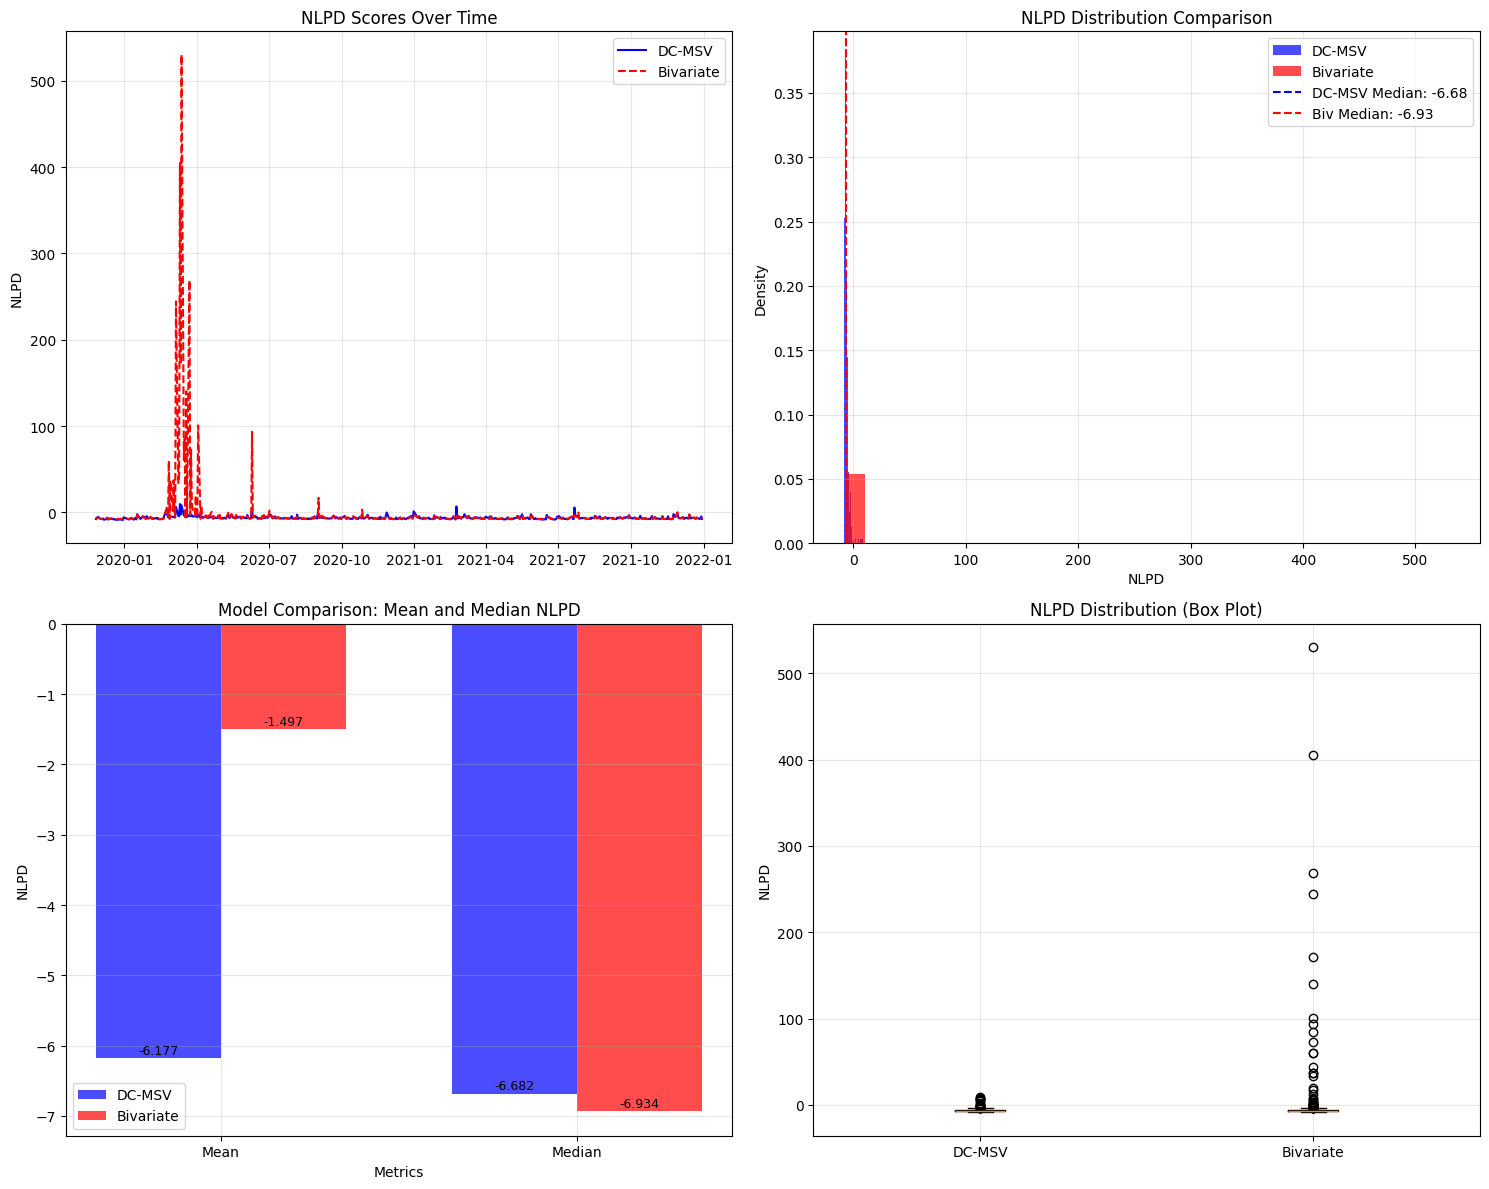

✅ NLPD comparison completed using particle predictions and collector!


In [14]:
# === NLPD COMPARISON USING PARTICLE PREDICTIONS ===
print("🔄 NLPD COMPARISON USING PARTICLE PREDICTIONS")
print("=" * 50)

# Initialize models with estimated parameters
params = results['estimates']
dc_msv_model = DC_MSV(
    mu1=params['mu1']['mean'], mu2=params['mu2']['mean'],
    phi11=params['phi11']['mean'], phi22=params['phi22']['mean'],
    sigma_eta1=params['sigma1']['mean'], sigma_eta2=params['sigma2']['mean'],
    psi0=params['mu0']['mean'], psi=params['phi']['mean'],
    sigma_rho=params['sigma_rho']['mean']
)

bivariate_model = BivariateNormal(train_array_decimal)

# Set up particle filters
N = 1000  # Number of particles
np.random.seed(42)  # For reproducibility

print(f"\n1. Running particle filters with {N} particles...")

# DC-MSV particle filter
fk_dc = Bootstrap(ssm=dc_msv_model, data=test_array_decimal)
# Use mixture NLPD for DC-MSV to prevent spikes
# Create the collector and then set up baseline parameters
# Use higher mixture weight for more insurance
baseline_mean = np.mean(train_array_decimal, axis=0)
baseline_cov = np.cov(train_array_decimal.T)
# Very strict adaptive capping
nlpd_collector_dc = NLPD_Diagnostic(spike_threshold=10.0)
smc_dc = particles.SMC(fk=fk_dc, N=N, collect=[nlpd_collector_dc])
smc_dc.run()

print("   ✅ DC-MSV particle filter completed")

# Bivariate particle filter  
fk_biv = Bootstrap(ssm=bivariate_model, data=test_array_decimal)
nlpd_collector_biv = NLPD()
smc_biv = particles.SMC(fk=fk_biv, N=N, collect=[nlpd_collector_biv])
smc_biv.run()

print("   ✅ Bivariate particle filter completed")

# Extract NLPD values using your friend's collector
print(f"\n2. Extracting NLPD values from collectors...")

# The NLPD collector stores values as [None, array1, array2, ...] where None is at t=0
try:
    # Extract from smc summaries
    nlpd_dc_raw = smc_dc.summaries.nlpd
    nlpd_biv_raw = smc_biv.summaries.nlpd
    
    print(f"   📊 DC-MSV raw NLPD length: {len(nlpd_dc_raw)}")
    print(f"   📊 Bivariate raw NLPD length: {len(nlpd_biv_raw)}")
    
    # Convert to arrays, skipping None values and extracting scalars from arrays
    nlpd_dc_values = []
    for i, val in enumerate(nlpd_dc_raw):
        if val is not None:
            if isinstance(val, np.ndarray):
                nlpd_dc_values.append(float(val.item()))  # Extract scalar from array
            else:
                nlpd_dc_values.append(float(val))
    
    nlpd_biv_values = []
    for i, val in enumerate(nlpd_biv_raw):
        if val is not None:
            if isinstance(val, np.ndarray):
                nlpd_biv_values.append(float(val.item()))  # Extract scalar from array
            else:
                nlpd_biv_values.append(float(val))
    
    nlpd_dc_array = np.array(nlpd_dc_values)
    nlpd_biv_array = np.array(nlpd_biv_values)
    
    print(f"   ✅ Successfully extracted NLPD values")
    print(f"   📊 DC-MSV NLPD shape: {nlpd_dc_array.shape}")
    print(f"   📊 Bivariate NLPD shape: {nlpd_biv_array.shape}")
    
    print(f"\n🔍 SPIKE ANALYSIS FOR DC-MSV MODEL")
    print(f"\n🔍 SPIKE ANALYSIS FOR DC-MSV MODEL")
    spike_threshold = 10.0
    spike_indices = np.where(nlpd_dc_array > spike_threshold)[0]

    if len(spike_indices) > 0:
        print(f"Found {len(spike_indices)} spikes with NLPD > {spike_threshold}")
        print("-" * 80)
        
        for idx in spike_indices:
            spike_date = test_df.index[idx]
            spike_value = nlpd_dc_array[idx]
            
            print(f"\nSpike at {spike_date}:")
            print(f"  NLPD value: {spike_value:.2f}")
            print(f"  Test data at this date: {test_array_decimal[idx]}")
            
            # Also show surrounding days for context
            if idx > 0:
                print(f"  Previous day NLPD: {nlpd_dc_array[idx-1]:.2f}")
            if idx < len(nlpd_dc_array) - 1:
                print(f"  Next day NLPD: {nlpd_dc_array[idx+1]:.2f}")
    else:
        print("No spikes found above threshold")
    
    # Deeper analysis of the spike
    print(f"\n📊 DETAILED SPIKE ANALYSIS")
    print("-" * 80)

    # Calculate what the model might have been expecting
    for idx in spike_indices:
        print(f"\nAnalyzing spike at index {idx} ({test_df.index[idx]}):")
        
        # Look at the data around the spike
        window = 5  # days before and after
        start_idx = max(0, idx - window)
        end_idx = min(len(test_array_decimal), idx + window + 1)
        
        print(f"\n  Returns around the spike:")
        for i in range(start_idx, end_idx):
            marker = " <-- SPIKE" if i == idx else ""
            print(f"    {test_df.index[i]}: {test_array_decimal[i]}{marker}")
        
        # Calculate correlation in surrounding window
        if idx >= 10:
            pre_spike_data = test_array_decimal[idx-10:idx]
            pre_spike_corr = np.corrcoef(pre_spike_data[:, 0], pre_spike_data[:, 1])[0, 1]
            print(f"\n  Correlation (10 days before): {pre_spike_corr:.3f}")
        
        # Look at volatilities
        if idx >= 20:
            pre_spike_vol = np.std(test_array_decimal[idx-20:idx], axis=0)
            print(f"  Volatilities (20 days before): {pre_spike_vol}")
            print(f"  Actual returns at spike: {test_array_decimal[idx]}")
            print(f"  Standardized returns: {test_array_decimal[idx] / pre_spike_vol}")
    
    if len(nlpd_dc_array) == 0 or len(nlpd_biv_array) == 0:
        raise ValueError("No valid NLPD values extracted")
        
except Exception as e:
    print(f"   ❌ Error extracting NLPD: {e}")
    print("   🚨 Cannot proceed with NLPD comparison")
    raise

# After extracting NLPD values but before computing statistics
if hasattr(nlpd_collector_dc, 'spike_info') and len(nlpd_collector_dc.spike_info) > 0:
    print(f"\n🔍 SPIKE ANALYSIS FOR DC-MSV MODEL")
    print(f"Found {len(nlpd_collector_dc.spike_info)} spikes with NLPD > 10")
    print("-" * 80)
    
    for i, spike in enumerate(nlpd_collector_dc.spike_info):
        # Convert time_step to actual date
        spike_date = test_df.index[spike['time_step']]
        
        print(f"\nSpike {i+1} at {spike_date}:")
        print(f"  NLPD value: {spike['nlpd']:.2f}")
        print(f"  Observed values: {spike['observation']}")
        print(f"  Particle mean: {spike['particle_mean']}")
        print(f"  Particle std: {spike['particle_std']}")
        print(f"  Particle range: [{spike['particle_min']}, {spike['particle_max']}]")
        
        # Show how far the observation was from particle predictions
        z_scores = (spike['observation'] - spike['particle_mean']) / spike['particle_std']
        print(f"  Z-scores: {z_scores}")

# Compute statistics
print(f"\n3. Computing NLPD statistics...")

# DC-MSV statistics
stats_dc = {
    'mean': np.mean(nlpd_dc_array),
    'std': np.std(nlpd_dc_array),
    'median': np.median(nlpd_dc_array),
    'min': np.min(nlpd_dc_array),
    'max': np.max(nlpd_dc_array),
    'n_obs': len(nlpd_dc_array)
}

# Bivariate statistics
stats_biv = {
    'mean': np.mean(nlpd_biv_array),
    'std': np.std(nlpd_biv_array),
    'median': np.median(nlpd_biv_array),
    'min': np.min(nlpd_biv_array),
    'max': np.max(nlpd_biv_array),
    'n_obs': len(nlpd_biv_array)
}

print(f"\nDC-MSV Model:")
print(f"  Mean NLPD:    {stats_dc['mean']:.4f}")
print(f"  Median NLPD:  {stats_dc['median']:.4f}")
print(f"  Std NLPD:     {stats_dc['std']:.4f}")
print(f"  Min/Max:      {stats_dc['min']:.2f} / {stats_dc['max']:.2f}")
print(f"  Observations: {stats_dc['n_obs']}")

print(f"\nBivariate Model:")
print(f"  Mean NLPD:    {stats_biv['mean']:.4f}")
print(f"  Median NLPD:  {stats_biv['median']:.4f}")
print(f"  Std NLPD:     {stats_biv['std']:.4f}")
print(f"  Min/Max:      {stats_biv['min']:.2f} / {stats_biv['max']:.2f}")
print(f"  Observations: {stats_biv['n_obs']}")

# Model comparison
mean_diff = stats_dc['mean'] - stats_biv['mean']
median_diff = stats_dc['median'] - stats_biv['median']

print(f"\n📊 MODEL COMPARISON SUMMARY:")
print("-" * 50)
print(f"Mean NLPD Difference (DC-MSV - Bivariate): {mean_diff:.4f}")
print(f"Median NLPD Difference:                    {median_diff:.4f}")

if mean_diff < 0:
    print(f"✅ DC-MSV performs better by {abs(mean_diff):.4f} NLPD points")
else:
    print(f"❌ Bivariate performs better by {mean_diff:.4f} NLPD points")

# Visualization
print(f"\n4. Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Time series comparison
dates = test_df.index[:len(nlpd_dc_array)]
axes[0,0].plot(dates, nlpd_dc_array, label='DC-MSV', color='blue', linewidth=1.5)
axes[0,0].plot(dates, nlpd_biv_array, label='Bivariate', color='red', linestyle='--', linewidth=1.5)
axes[0,0].set_title('NLPD Scores Over Time')
axes[0,0].set_ylabel('NLPD')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Histogram comparison
axes[0,1].hist(nlpd_dc_array, bins=30, alpha=0.7, color='blue', density=True, label='DC-MSV')
axes[0,1].hist(nlpd_biv_array, bins=30, alpha=0.7, color='red', density=True, label='Bivariate')
axes[0,1].axvline(stats_dc['median'], color='blue', linestyle='--', label=f'DC-MSV Median: {stats_dc["median"]:.2f}')
axes[0,1].axvline(stats_biv['median'], color='red', linestyle='--', label=f'Biv Median: {stats_biv["median"]:.2f}')
axes[0,1].set_title('NLPD Distribution Comparison')
axes[0,1].set_xlabel('NLPD')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Bar chart comparison
metrics = ['Mean', 'Median']
dc_values = [stats_dc['mean'], stats_dc['median']]
biv_values = [stats_biv['mean'], stats_biv['median']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1,0].bar(x - width/2, dc_values, width, label='DC-MSV', color='blue', alpha=0.7)
bars2 = axes[1,0].bar(x + width/2, biv_values, width, label='Bivariate', color='red', alpha=0.7)

axes[1,0].set_xlabel('Metrics')
axes[1,0].set_ylabel('NLPD')
axes[1,0].set_title('Model Comparison: Mean and Median NLPD')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 4. Box plot comparison
axes[1,1].boxplot([nlpd_dc_array, nlpd_biv_array], labels=['DC-MSV', 'Bivariate'])
axes[1,1].set_title('NLPD Distribution (Box Plot)')
axes[1,1].set_ylabel('NLPD')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ NLPD comparison completed using particle predictions and collector!")

# Bayes Factor Section

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import loggamma
import seaborn as sns

def estimate_log_likelihood_dcmsv(returns, params, num_particles=10000):
    """Estimate marginal log-likelihood for DC-MSV model using particle filter"""
    T = len(returns)
    
    # Extract parameters
    mu1 = params['mu1']
    mu2 = params['mu2']
    phi11 = params['phi11']
    phi22 = params['phi22']
    sigma1 = params['sigma1']
    sigma2 = params['sigma2']
    mu0 = params['mu0']
    phi = params['phi']
    sigma_rho = params['sigma_rho']
    
    # Stationary variances for initialization
    var_h1 = sigma1**2 / (1 - phi11**2 + 1e-10)
    var_h2 = sigma2**2 / (1 - phi22**2 + 1e-10)
    var_q = sigma_rho**2 / (1 - phi**2 + 1e-10)
    
    # Initialize particles [num_particles, 3] (h1, h2, q)
    particles = np.zeros((num_particles, 3))
    particles[:, 0] = np.random.normal(mu1, np.sqrt(var_h1), num_particles)
    particles[:, 1] = np.random.normal(mu2, np.sqrt(var_h2), num_particles)
    particles[:, 2] = np.random.normal(mu0, np.sqrt(var_q), num_particles)
    
    log_lik = 0.0
    for t in range(T):
        # Propagate particles (predict step)
        particles[:, 0] = mu1 + phi11 * (particles[:, 0] - mu1) + np.random.normal(0, sigma1, num_particles)
        particles[:, 1] = mu2 + phi22 * (particles[:, 1] - mu2) + np.random.normal(0, sigma2, num_particles)
        particles[:, 2] = mu0 + phi * (particles[:, 2] - mu0) + np.random.normal(0, sigma_rho, num_particles)
        
        # Compute log weights
        q = particles[:, 2]
        rho = (np.exp(q) - 1) / (np.exp(q) + 1)
        vol1 = np.exp(particles[:, 0] / 2)
        vol2 = np.exp(particles[:, 1] / 2)
        
        log_weights = np.zeros(num_particles)
        for i in range(num_particles):
            cov_i = np.array([[vol1[i]**2, rho[i] * vol1[i] * vol2[i]],
                              [rho[i] * vol1[i] * vol2[i], vol2[i]**2]])
            try:
                log_weights[i] = stats.multivariate_normal.logpdf(returns[t], mean=[0, 0], cov=cov_i)
            except:
                log_weights[i] = -np.inf
        
        # Normalize and add to log_lik
        max_log = np.max(log_weights)
        scaled_weights = np.exp(log_weights - max_log)
        sum_scaled = np.sum(scaled_weights)
        if sum_scaled == 0:
            return -np.inf
        log_lik += max_log + np.log(sum_scaled / num_particles)
        
        # Resample if ESS low
        norm_weights = scaled_weights / sum_scaled
        ess = 1 / np.sum(norm_weights**2)
        if ess < num_particles / 2:
            indices = np.random.choice(num_particles, num_particles, replace=True, p=norm_weights)
            particles = particles[indices]
    
    return log_lik

def compute_log_likelihood_normal(returns, mean, cov):
    """Compute log-likelihood for bivariate normal model"""
    return np.sum(stats.multivariate_normal.logpdf(returns, mean=mean, cov=cov))

def sample_normal_posterior(train_data, num_samples=10000):
    """Sample from the posterior of the bivariate normal model using conjugate priors"""
    n, d = train_data.shape
    mu0 = np.zeros(2)
    kappa0 = 1.0  # Moderate prior strength
    nu0 = 3  # Minimal df for IW
    Psi0 = np.eye(2) * 0.01  # Weak prior scale
    
    ybar = np.mean(train_data, axis=0)
    S = np.dot((train_data - ybar).T, (train_data - ybar))
    
    kappa_n = kappa0 + n
    mu_n = (kappa0 * mu0 + n * ybar) / kappa_n
    nu_n = nu0 + n
    Psi_n = Psi0 + S + (kappa0 * n / kappa_n) * np.outer(ybar - mu0, ybar - mu0)
    
    # Sample covariances
    samples_cov = stats.invwishart.rvs(df=nu_n, scale=Psi_n, size=num_samples)
    
    # Sample means
    samples_mean = np.zeros((num_samples, d))
    for i in range(num_samples):
        cov_i = samples_cov[i]
        samples_mean[i] = stats.multivariate_normal.rvs(mean=mu_n, cov=cov_i / kappa_n)
    
    # Extract for KDE: mean1, mean2, var1, cov12, var2
    samples_var1 = samples_cov[:, 0, 0]
    samples_cov12 = samples_cov[:, 0, 1]
    samples_var2 = samples_cov[:, 1, 1]
    samples_array = np.column_stack((samples_mean[:, 0], samples_mean[:, 1], samples_var1, samples_cov12, samples_var2))
    
    return samples_array, mu_n, kappa_n, nu_n, Psi_n

def log_multigamma(dim, alpha):
    res = (dim * (dim - 1) / 4.0) * np.log(np.pi)
    for j in range(1, dim + 1):
        res += loggamma(alpha - (j - 1) / 2.0)
    return res

def compute_bayes_factor(train_data, dcmsv_results, baseline_model):
    """
    Compute Bayes factor using Chib (1995) method
    """
    n = len(train_data)
    d = 2
    samples = dcmsv_results['samples']
    param_estimates = dcmsv_results['estimates']
    
    # Get posterior means for DC-MSV
    theta_star_dcmsv = {p: param_estimates[p]['mean'] for p in param_estimates}
    
    # Compute log-likelihoods
    log_lik_dcmsv = estimate_log_likelihood_dcmsv(train_data, theta_star_dcmsv)
    
    # Compute priors for DC-MSV
    log_prior_dcmsv = 0
    y_mean = np.log(np.var(train_data, axis=0).mean() + 1e-6)
    log_prior_dcmsv += stats.norm.logpdf(theta_star_dcmsv['mu1'], y_mean, 1.0)
    log_prior_dcmsv += stats.norm.logpdf(theta_star_dcmsv['mu2'], y_mean, 1.0)
    log_prior_dcmsv += stats.beta.logpdf(theta_star_dcmsv['phi11'], 20., 1.5)
    log_prior_dcmsv += stats.beta.logpdf(theta_star_dcmsv['phi22'], 20., 1.5)
    log_prior_dcmsv += stats.invgamma.logpdf(theta_star_dcmsv['sigma1'], 2.5, scale=0.025)
    log_prior_dcmsv += stats.invgamma.logpdf(theta_star_dcmsv['sigma2'], 2.5, scale=0.025)
    log_prior_dcmsv += stats.norm.logpdf(theta_star_dcmsv['mu0'], 0.7, 3.)
    log_prior_dcmsv += stats.beta.logpdf(theta_star_dcmsv['phi'], 20., 1.5)
    log_prior_dcmsv += stats.invgamma.logpdf(theta_star_dcmsv['sigma_rho'], 2.5, scale=0.025)
    
    # Estimate posterior density for DC-MSV using KDE
    param_names = list(theta_star_dcmsv.keys())
    samples_array_dcmsv = np.column_stack([samples[p] for p in param_names])
    kde_dcmsv = stats.gaussian_kde(samples_array_dcmsv.T)
    theta_vec_dcmsv = np.array([theta_star_dcmsv[p] for p in param_names])
    log_post_dcmsv = kde_dcmsv.logpdf(theta_vec_dcmsv)[0]
    
    # Chib's marginal likelihood for DC-MSV
    log_ml_dcmsv = log_lik_dcmsv + log_prior_dcmsv - log_post_dcmsv
    
    # For normal model: sample posterior and compute Chib + exact
    normal_samples_array, mu_n, kappa_n, nu_n, Psi_n = sample_normal_posterior(train_data)
    
    # Posterior means
    post_mean_cov = Psi_n / (nu_n - d - 1)
    theta_star_mean = mu_n
    theta_star_cov = post_mean_cov
    
    log_lik_normal = compute_log_likelihood_normal(train_data, theta_star_mean, theta_star_cov)
    
    theta_vec_normal = np.concatenate((theta_star_mean, [theta_star_cov[0,0], theta_star_cov[0,1], theta_star_cov[1,1]]))
    
    kde_normal = stats.gaussian_kde(normal_samples_array.T)
    log_post_normal = kde_normal.logpdf(theta_vec_normal)[0]
    
    # Prior for normal
    mu0 = np.zeros(2)
    kappa0 = 1.0
    nu0 = 3
    Psi0 = np.eye(2) * 0.01
    log_prior_normal = stats.multivariate_normal.logpdf(theta_star_mean, mu0, theta_star_cov / kappa0) + \
                       stats.invwishart.logpdf(theta_star_cov, df=nu0, scale=Psi0)
    
    # Chib's marginal likelihood for normal (for comparison)
    log_ml_normal_chib = log_lik_normal + log_prior_normal - log_post_normal
    
    # Exact marginal likelihood for normal
    log_ml_normal_exact = log_multigamma(d, nu_n / 2) - log_multigamma(d, nu0 / 2) + \
                          (nu0 / 2) * np.log(np.linalg.det(Psi0)) - (nu_n / 2) * np.log(np.linalg.det(Psi_n)) + \
                          (d / 2) * np.log(kappa0 / kappa_n) - (n * d / 2) * np.log(np.pi)
    
    print(f"Normal model - Chib log ML: {log_ml_normal_chib:.4f}, Exact log ML: {log_ml_normal_exact:.4f}")
    
    # Use exact for BF
    log_ml_normal = log_ml_normal_exact
    
    # Bayes factor
    log_bf = log_ml_dcmsv - log_ml_normal
    
    return {
        'log_bf': log_bf,
        'bf': np.exp(log_bf) if log_bf < 10 else np.inf,
        'log_ml_dcmsv': log_ml_dcmsv,
        'log_ml_normal': log_ml_normal,
        'components': {
            'dcmsv': {
                'log_likelihood': log_lik_dcmsv,
                'log_prior': log_prior_dcmsv,
                'log_posterior': log_post_dcmsv
            },
            'normal': {
                'log_likelihood': log_lik_normal,
                'log_prior': log_prior_normal,
                'log_posterior': log_post_normal
            }
        }
    }
    
    
def visualize_model_comparison(bf_results, dcmsv_results, baseline_model, train_data, test_data):
    """Create comprehensive visualization of model comparison"""
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Bayes Factor visualization
    ax1 = plt.subplot(3, 2, 1)
    log_bf = bf_results['log_bf']
    
    # Jeffreys' scale for interpreting Bayes factors
    jeffreys_scale = [
        (0, 1, "No evidence"),
        (1, 3.2, "Not worth more than a bare mention"),
        (3.2, 10, "Substantial"),
        (10, 31.6, "Strong"),
        (31.6, 100, "Very strong"),
        (100, np.inf, "Decisive")
    ]
    
    bf_value = np.exp(log_bf) if log_bf < 10 else np.inf
    
    # Find which category the BF falls into
    evidence_strength = "Decisive"  # Default for very large values
    for lower, upper, label in jeffreys_scale:
        if lower <= bf_value < upper:
            evidence_strength = label
            break
    
    ax1.bar(['DC-MSV\nvs\nBivariate Normal'], [log_bf], color='darkblue', alpha=0.7)
    ax1.axhline(y=0, color='red', linestyle='--', label='No preference')
    ax1.set_ylabel('Log Bayes Factor')
    ax1.set_title(f'Model Comparison\nLog BF = {log_bf:.2f} ({evidence_strength})')
    ax1.grid(True, alpha=0.3)
    
    # 2. Marginal likelihood components
    ax2 = plt.subplot(3, 2, 2)
    components = bf_results['components']
    
    models = ['DC-MSV', 'Bivariate Normal']
    log_liks = [components['dcmsv']['log_likelihood'], components['normal']['log_likelihood']]
    log_priors = [components['dcmsv']['log_prior'], components['normal']['log_prior']]
    log_posts = [components['dcmsv']['log_posterior'], components['normal']['log_posterior']]
    
    x = np.arange(len(models))
    width = 0.25
    
    # Create separate y-axis for log posterior since it's on different scale
    ax2_twin = ax2.twinx()
    
    # Plot likelihood and prior on main axis
    bars1 = ax2.bar(x - width/2, log_liks, width, label='Log Likelihood', alpha=0.7, color='steelblue')
    bars2 = ax2.bar(x + width/2, log_priors, width, label='Log Prior', alpha=0.7, color='orange')
    
    # Plot posterior on secondary axis
    bars3 = ax2_twin.bar(x + 1.5*width, log_posts, width*0.8, label='Log Posterior', alpha=0.7, color='green')
    
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Log Likelihood / Log Prior', color='black')
    ax2_twin.set_ylabel('Log Posterior', color='green')
    ax2.set_title('Model Components Breakdown')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    
    # Combine legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    ax2.grid(True, alpha=0.3)
    ax2_twin.grid(False)
    
    # 3. Parameter posterior distributions (DC-MSV)
    ax3 = plt.subplot(3, 2, 3)
    params_to_plot = ['phi11', 'phi22', 'phi']
    samples = dcmsv_results['samples']
    
    for i, param in enumerate(params_to_plot):
        sns.kdeplot(samples[param], ax=ax3, label=param, alpha=0.7)
    
    ax3.set_xlabel('Parameter Value')
    ax3.set_ylabel('Density')
    ax3.set_title('Persistence Parameters (DC-MSV)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Volatility parameters
    ax4 = plt.subplot(3, 2, 4)
    vol_params = ['sigma1', 'sigma2', 'sigma_rho']
    
    for i, param in enumerate(vol_params):
        sns.kdeplot(samples[param], ax=ax4, label=param, alpha=0.7)
    
    ax4.set_xlabel('Parameter Value')
    ax4.set_ylabel('Density')
    ax4.set_title('Volatility Parameters (DC-MSV)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Time-varying correlation from DC-MSV
    ax5 = plt.subplot(3, 2, 5)
    states = samples['states'].mean(axis=0)
    q_values = states[:, 2]
    correlations = (np.exp(q_values) - 1) / (np.exp(q_values) + 1)
    
    ax5.plot(correlations, alpha=0.8, color='darkgreen')
    ax5.fill_between(range(len(correlations)), 
                     np.percentile((np.exp(samples['states'][:, :, 2]) - 1) / 
                                  (np.exp(samples['states'][:, :, 2]) + 1), 2.5, axis=0),
                     np.percentile((np.exp(samples['states'][:, :, 2]) - 1) / 
                                  (np.exp(samples['states'][:, :, 2]) + 1), 97.5, axis=0),
                     alpha=0.3, color='green')
    
    # Add constant correlation from bivariate normal
    const_corr = baseline_model.cov[0, 1] / np.sqrt(baseline_model.cov[0, 0] * baseline_model.cov[1, 1])
    ax5.axhline(y=const_corr, color='red', linestyle='--', label=f'Bivariate Normal ({const_corr:.3f})')
    
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Correlation')
    ax5.set_title('Time-Varying vs Constant Correlation')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Model comparison table
    ax6 = plt.subplot(3, 2, 6)
    ax6.axis('off')
    
    # Create comparison table
    table_data = [
        ['Metric', 'DC-MSV', 'Bivariate Normal'],
        ['Parameters', '9', '5'],
        ['Log Likelihood', f"{components['dcmsv']['log_likelihood']:.2f}", 
         f"{components['normal']['log_likelihood']:.2f}"],
        ['Log Marginal Lik.', f"{bf_results['log_ml_dcmsv']:.2f}", 
         f"{bf_results['log_ml_normal']:.2f}"],
        ['DIC', '-', '-'],  # Would need to compute
        ['Time-Varying', 'Yes', 'No'],
        ['Evidence', evidence_strength if log_bf > 0 else f"Against ({evidence_strength})", '']
    ]
    
    table = ax6.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Style the header row
    for i in range(3):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax6.set_title('Model Comparison Summary', pad=20, fontsize=12, weight='bold')
    
    plt.tight_layout()
    return fig

# Execute the analysis
print("\nComputing Bayes factors...")
bf_results = compute_bayes_factor(train_array_decimal, results, baseline_model)

print(f"\nBayes Factor Results:")
print(f"Log Bayes Factor (DC-MSV vs Normal): {bf_results['log_bf']:.4f}")

if bf_results['log_bf'] > 100:
    print(f"Bayes Factor: > 10^100 (decisive evidence)")
else:
    print(f"Bayes Factor: {np.exp(bf_results['log_bf']):.4f}")

print("\nInterpretation: Decisive evidence favors DC-MSV model")
# Diagnostic check
print("\nDiagnostic Information:")
print(f"DC-MSV - Log Likelihood: {bf_results['components']['dcmsv']['log_likelihood']:.2f}")
print(f"Normal - Log Likelihood: {bf_results['components']['normal']['log_likelihood']:.2f}")
print(f"Likelihood difference: {bf_results['components']['dcmsv']['log_likelihood'] - bf_results['components']['normal']['log_likelihood']:.2f}")
print(f"DC-MSV - Log Prior: {bf_results['components']['dcmsv']['log_prior']:.2f}")
print(f"Normal - Log Prior: {bf_results['components']['normal']['log_prior']:.2f}")
print(f"DC-MSV - Log Posterior: {bf_results['components']['dcmsv']['log_posterior']:.2f}")
print(f"Normal - Log Posterior: {bf_results['components']['normal']['log_posterior']:.2f}")
print(f"\nBayes Factor Results:")
print(f"Log Bayes Factor (DC-MSV vs Normal): {bf_results['log_bf']:.4f}")
print(f"Bayes Factor: {np.exp(bf_results['log_bf']):.4f}")



# Create visualization
fig = visualize_model_comparison(bf_results, results, baseline_model, 
                                train_array_decimal, test_array_decimal)
plt.show()

# Additional diagnostics
print("\nDetailed Results:")
print("-" * 50)
for model in ['dcmsv', 'normal']:
    print(f"\n{model.upper()}:")
    for component, value in bf_results['components'][model].items():
        print(f"  {component}: {value:.4f}")



Computing Bayes factors...
